In [1]:
import numpy as np
import astropy.units as u
import astropy.table
import astropy.io.fits
import plasmapy
import pathlib
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, Gaussian1DKernel
import ndcube
from ndcube.extra_coords import QuantityTableCoordinate
import fiasco
import aiapy.response
from sunpy.coordinates import get_earth, Helioprojective

from fiasco.io import Parser
from fiasco.util import parse_ion_name
from synthesizAR.instruments import InstrumentDEM

from mocksipipeline.physics.spectral import get_spectral_tables
from mocksipipeline.detector.response import SpectrogramChannel, convolve_with_response, ThinFilmFilter
from overlappy.wcs import overlappogram_fits_wcs, pcij_matrix

# Spectral Decomposition 

Break down the MOXSI spectra into components based on element and ion

In [2]:
line_list = astropy.table.QTable.read('../data/moxsi-line-list.asdf')

In [3]:
unique_elements = np.unique(line_list['element'])

## Components in Flux

Look at the invididual components of the total flux to determine which elements are contributing most and where. This may help pin down the above issue of what lines are the most dominant/important

In [4]:
def dem_table_to_ndcube(dem_table):
    temperature = dem_table['temperature_bin_center']
    em = dem_table['dem']*np.gradient(temperature, edge_order=2)
    tab_coord = QuantityTableCoordinate(temperature,
                                        names='temperature',
                                        physical_types='phys.temperature')
    return ndcube.NDCube(em, wcs=tab_coord.wcs, meta=dem_table.meta)

In [5]:
def compute_total_flux(dem, spec_table, chan_1, chan_3, x_1, x_3):
    intensity = InstrumentDEM.calculate_intensity(dem, spec_table, {})
    flux_1 = convolve_with_response(intensity, chan_1, electrons=False, include_gain=False)
    flux_3 = convolve_with_response(intensity, chan_3, electrons=False, include_gain=False)
    flux_total = ndcube.NDCube(flux_1.data+np.interp(x_1, x_3, flux_3.data),
                               wcs=flux_1.wcs, unit=flux_1.unit)
    return flux_1, flux_3, flux_total

In [6]:
def degrade_spectra(spec, resolution, chan):
    std = resolution / (2*np.sqrt(2*np.log(2)))  # FWHM is 0.5 so convert to sigma using W = 2\sqrt{2\ln2}\sigma
    std_eff = (std / chan.spectral_resolution).to_value('pix')  # Scale sigma by bin width
    kernel = Gaussian1DKernel(std_eff)
    data_smooth = convolve(spec.data, kernel)
    return ndcube.NDCube(data_smooth, wcs=spec.wcs, meta=spec.meta, unit=spec.unit)

In [7]:
dem_flare_ext = dem_table_to_ndcube(Parser('flare_ext.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse())

In [8]:
dem_ar = dem_table_to_ndcube(Parser('active_region.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse())

In [9]:
ascii_dbase = '/Users/wtbarnes/ssw/packages/chianti/dbase/'
abundance_file_coronal = 'sun_coronal_1992_feldman_ext.abund'
abundance_file_photospheric = 'sun_photospheric_2015_scott.abund'
coronal_abundance_table = fiasco.io.Parser(abundance_file_coronal, ascii_dbase_root=ascii_dbase).parse()
photospheric_abundance_table = fiasco.io.Parser(abundance_file_photospheric, ascii_dbase_root=ascii_dbase).parse()

In [10]:
spec_tables = get_spectral_tables()

In [11]:
al_filter = ThinFilmFilter(elements='Al', thickness=150*u.nm, xrt_table='Chantler')
chan_o1 = SpectrogramChannel(1, al_filter)
chan_o3 = SpectrogramChannel(3, al_filter)

In [12]:
earth_observer = get_earth(time='2020-01-01 12:00:00')
flare_loc = SkyCoord(Tx=-900*u.arcsec, Ty=0*u.arcsec,
                     frame=Helioprojective(obstime=earth_observer.obstime, observer=earth_observer))
roll_angle = -90 * u.deg
dispersion_angle = 0*u.deg
wcs_o1 = overlappogram_fits_wcs(
    chan_o1.detector_shape,
    chan_o1.wavelength,
    (chan_o1.resolution[0], chan_o1.resolution[1], chan_o1.spectral_resolution),
    reference_pixel=chan_o1.reference_pixel,
    reference_coord=(0*u.arcsec, 0*u.arcsec, 0*u.angstrom),
    pc_matrix=pcij_matrix(roll_angle, dispersion_angle, order=chan_o1.spectral_order,),
    observer=earth_observer,
)
wcs_o3 = overlappogram_fits_wcs(
    chan_o3.detector_shape,
    chan_o3.wavelength,
    (chan_o3.resolution[0], chan_o3.resolution[1], chan_o3.spectral_resolution),
    reference_pixel=chan_o3.reference_pixel,
    reference_coord=(0*u.arcsec, 0*u.arcsec, 0*u.angstrom),
    pc_matrix=pcij_matrix(roll_angle, dispersion_angle, order=chan_o3.spectral_order,),
    observer=earth_observer,
)
pix_x_o1, _, _ = wcs_o1.world_to_pixel(flare_loc, chan_o1.wavelength)
pix_x_o3, _, _ = wcs_o3.world_to_pixel(flare_loc, chan_o3.wavelength)

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


### Flare DEM

#### Components

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:626: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


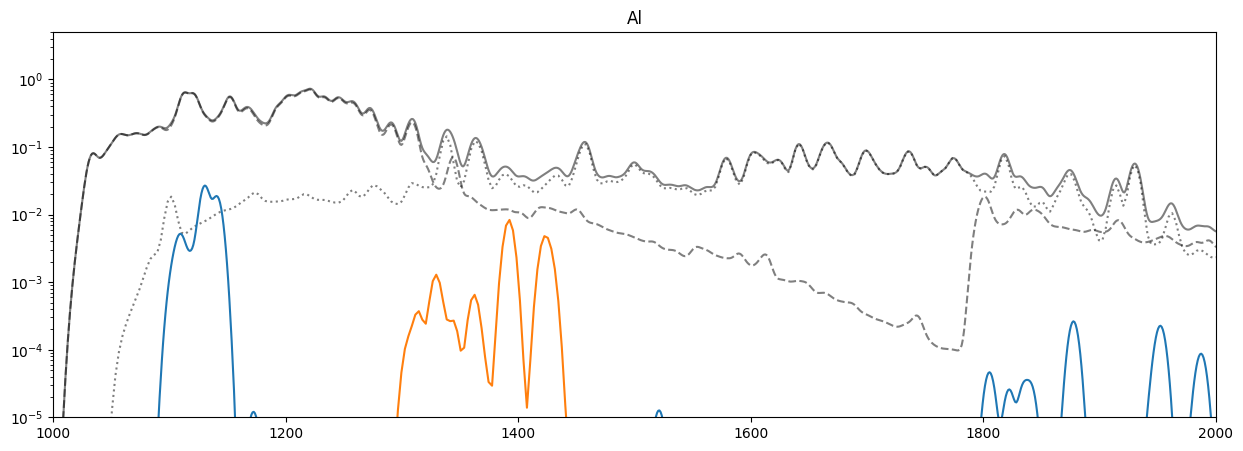

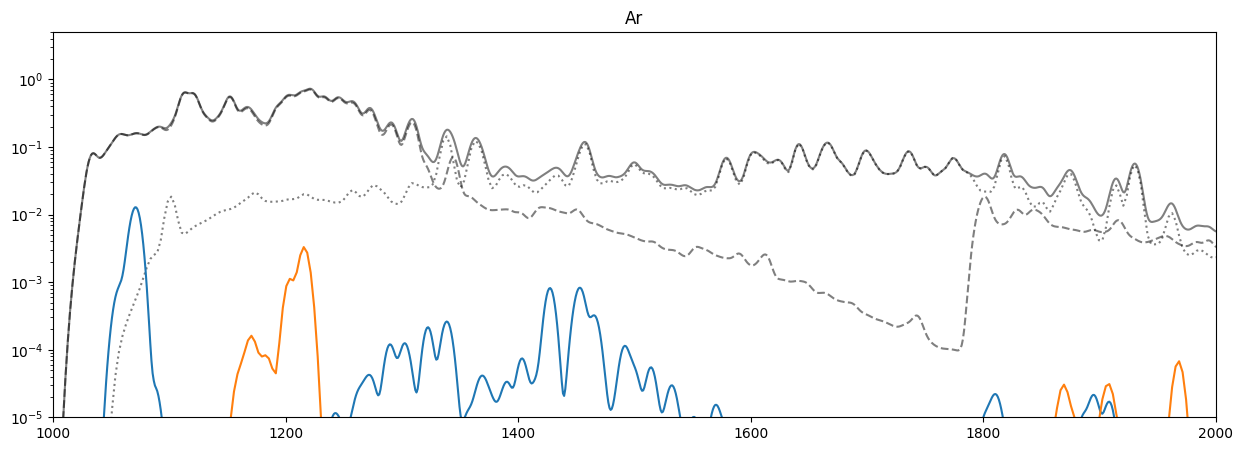

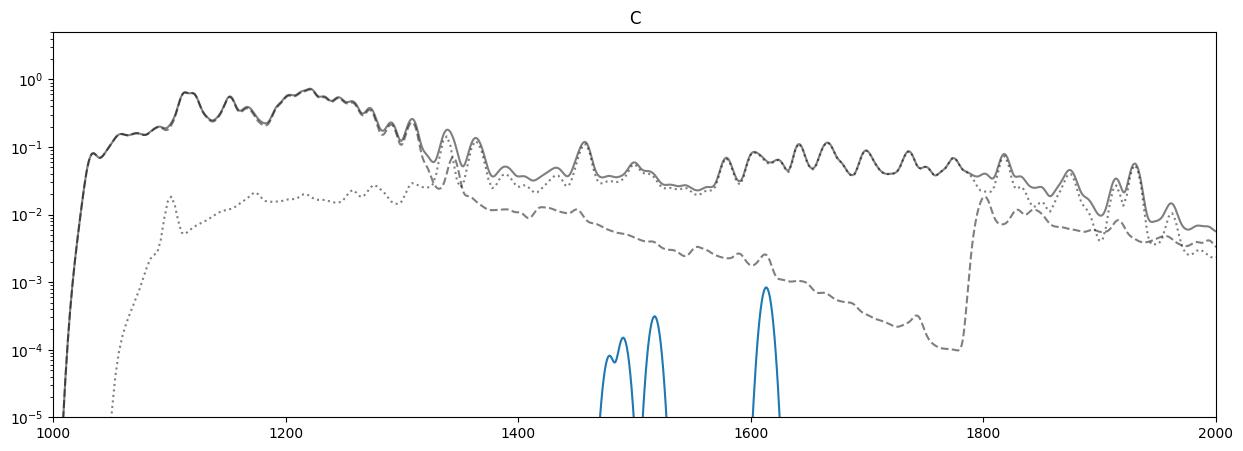

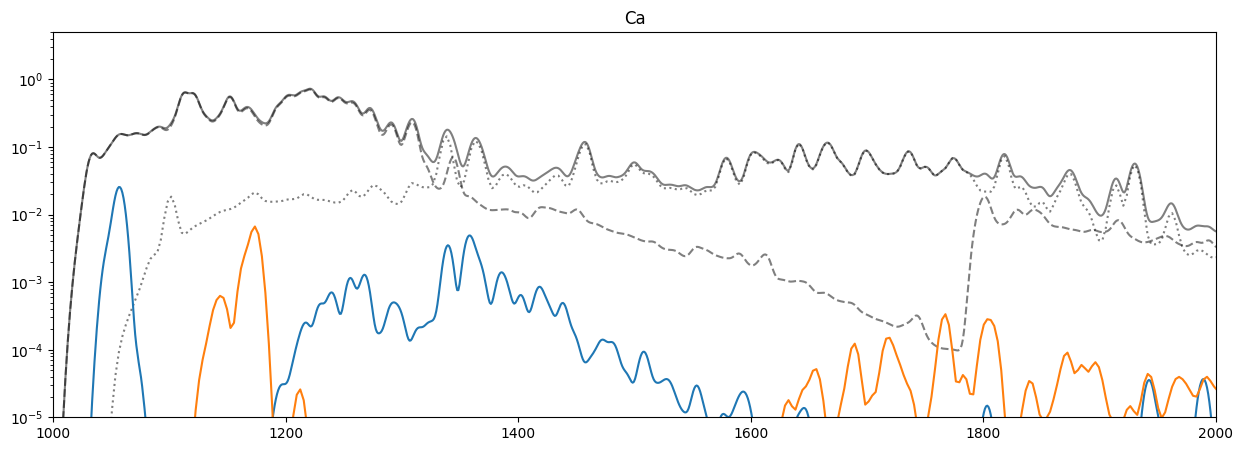

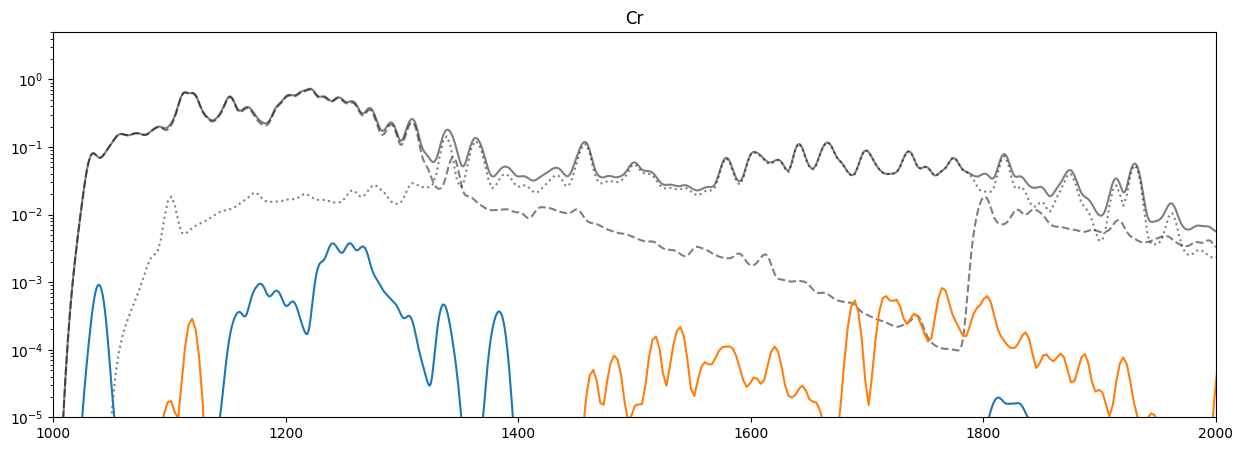

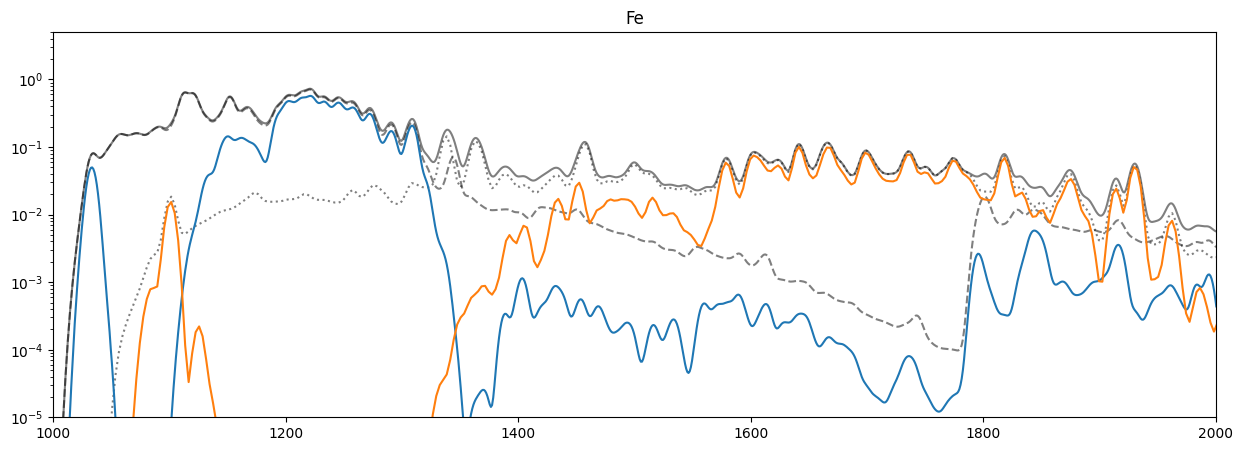

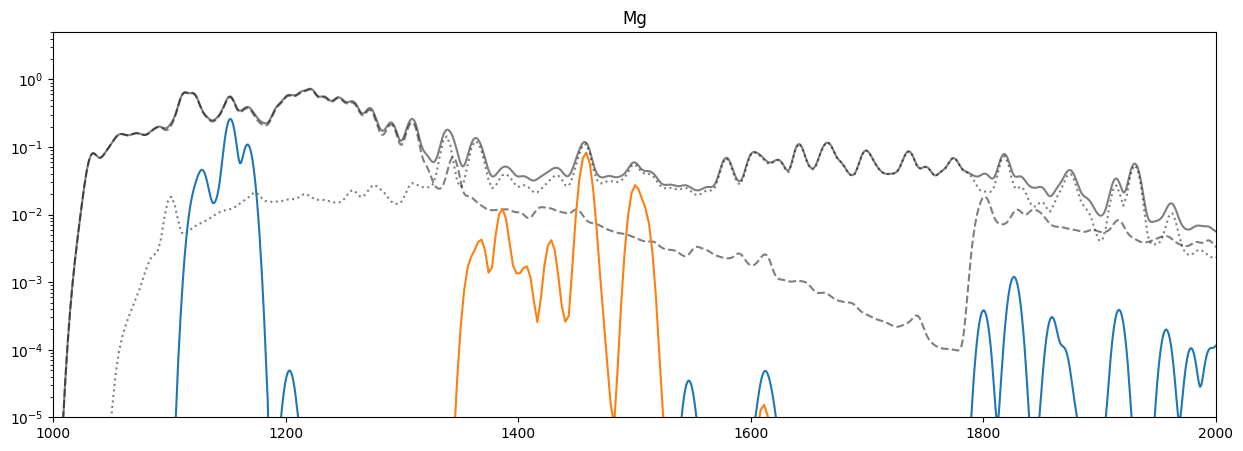

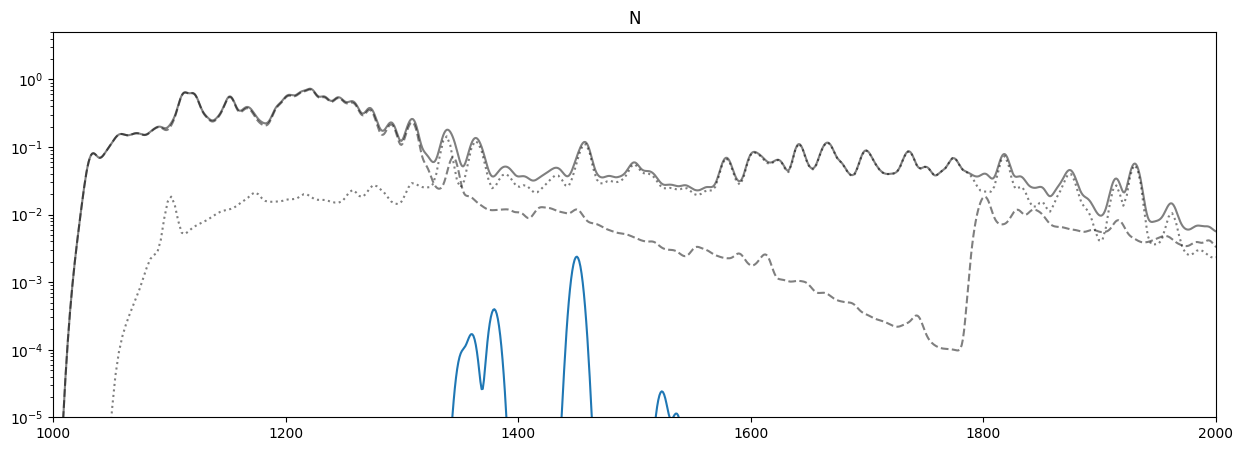

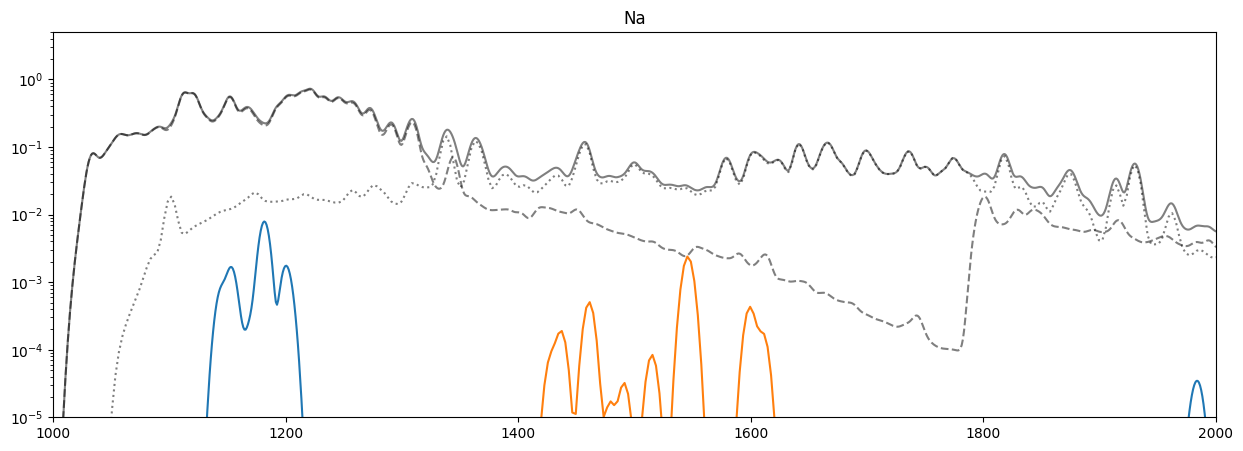

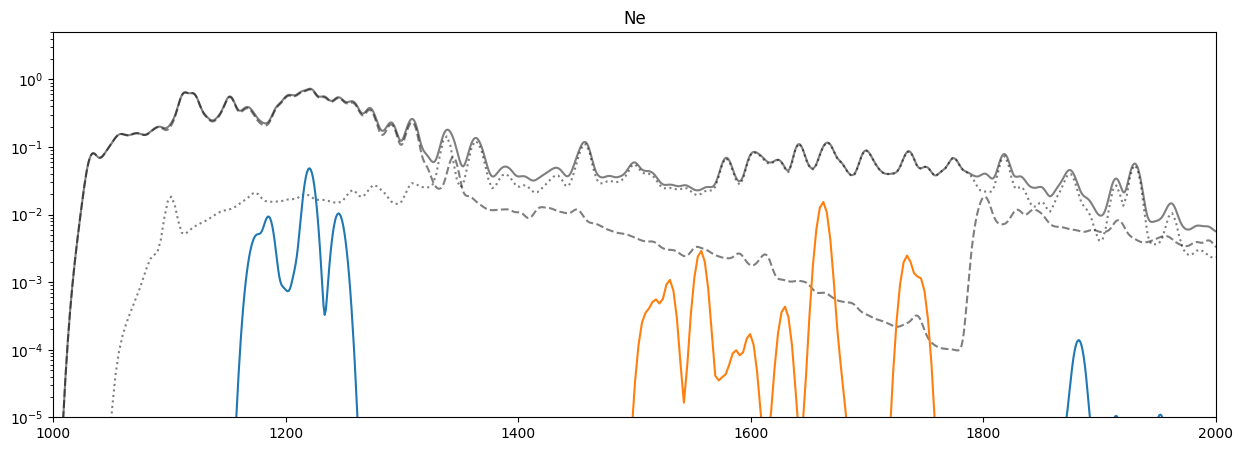

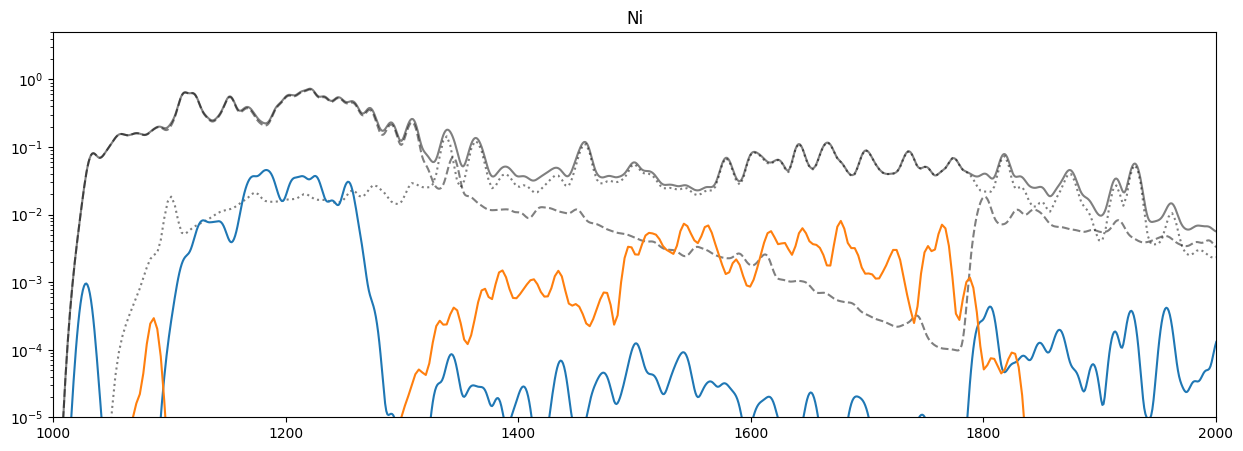

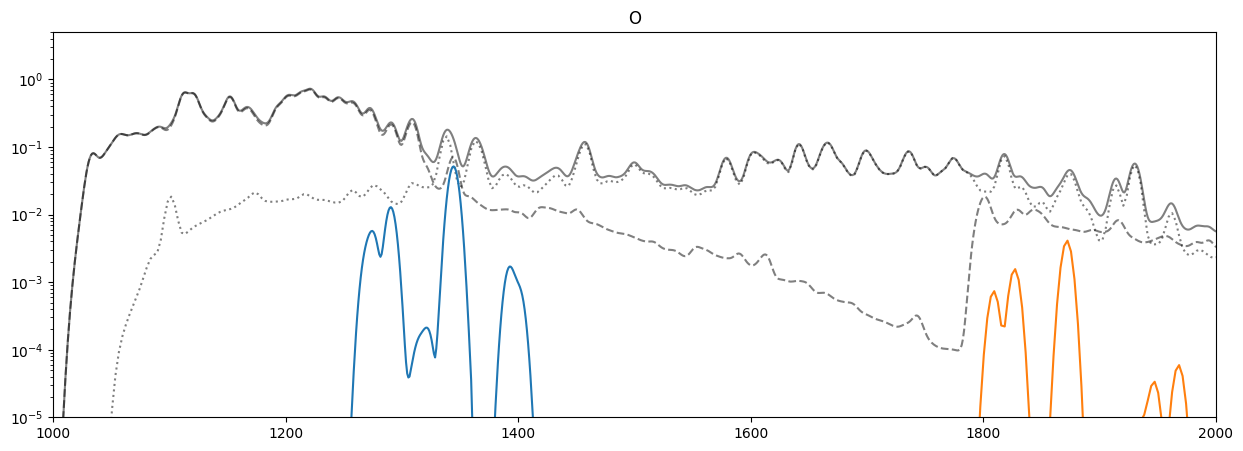

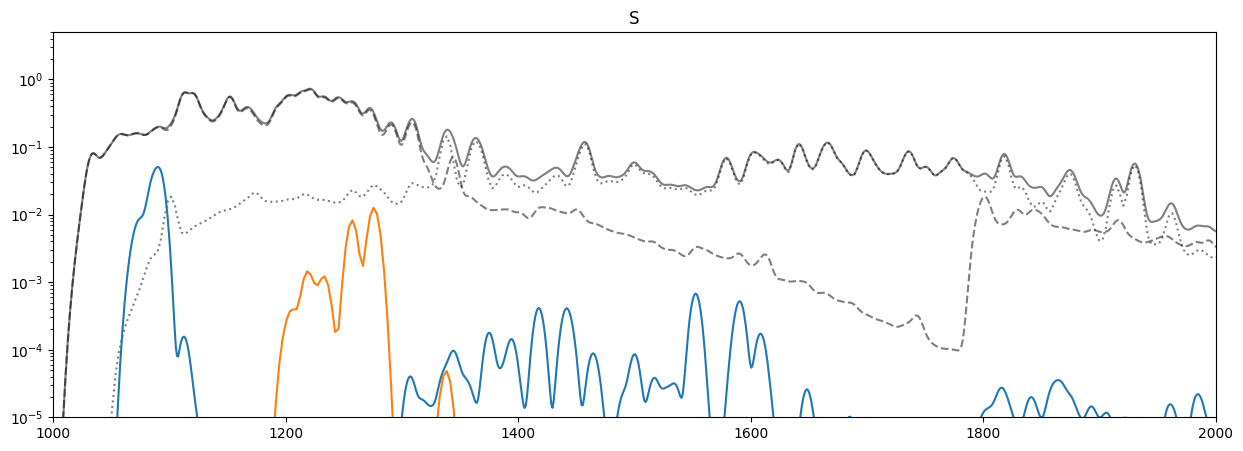

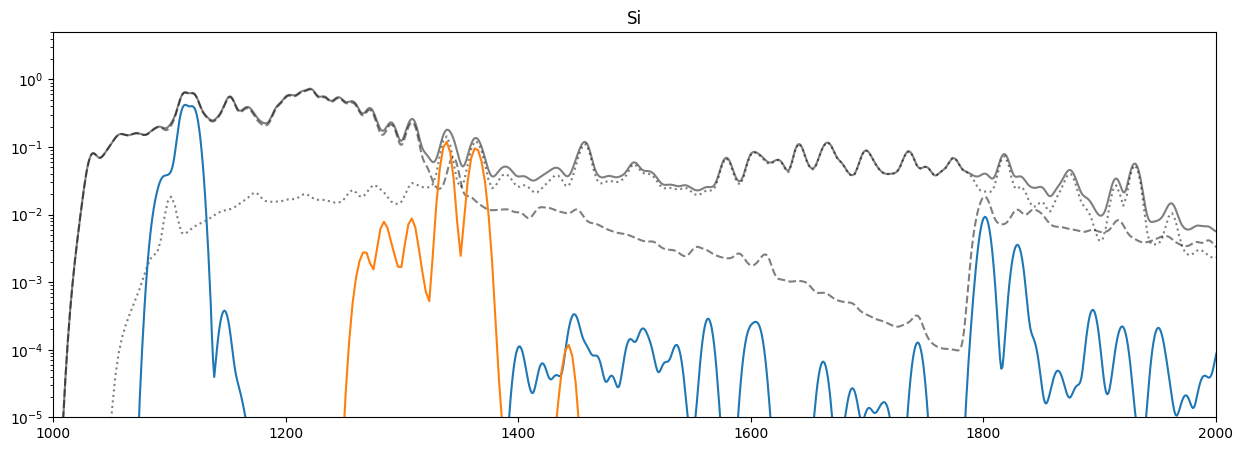

In [13]:
flux_1_all,flux_3_all,flux_total_all = compute_total_flux(dem_flare_ext, spec_tables['sun_coronal_1992_feldman_ext_all'], chan_o1, chan_o3, pix_x_o1, pix_x_o3)
blur = 0.5 * u.Angstrom
flux_1_all = degrade_spectra(flux_1_all, blur, chan_o1)
flux_3_all = degrade_spectra(flux_3_all, blur/3, chan_o1)
flux_total_all = degrade_spectra(flux_total_all, blur, chan_o1)
for el_name in unique_elements:
    spec_tab = get_spectral_tables(pattern=f'{el_name.lower()}_', sum_tables=True)
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()
    ax.plot(pix_x_o1, flux_total_all.data, color='k', alpha=.5)
    ax.plot(pix_x_o1, flux_1_all.data, color='k', alpha=.5, ls='--')
    ax.plot(pix_x_o3, flux_3_all.data, color='k', alpha=.5, ls=':')
    ab = fiasco.Element(el_name, 1*u.MK, abundance_filename='sun_coronal_1992_feldman_ext').abundance
    f1,f3,_ = compute_total_flux(dem_flare_ext, spec_tab, chan_o1, chan_o3, pix_x_o1, pix_x_o3)
    f1 = degrade_spectra(f1, blur, chan_o1)
    f3 = degrade_spectra(f3, blur/3, chan_o1)
    f1 = ab*f1
    f3 = ab*f3
    ax.plot(pix_x_o1, f1.data)
    ax.plot(pix_x_o3, f3.data)
    ax.set_yscale('log')
    ax.set_ylim(1e-5,5)
    ax.set_title(el_name)
    ax.set_xlim(1000,2000)

#### Combined

In [14]:
blur = 0.5 * u.angstrom

In [37]:
flare_line_labels = line_list[line_list['intensity_scaled (coronal)_flare_ext']>0.1]
flare_line_labels = flare_line_labels[['ion name', 'wavelength', 'ion id']]

(1000.0, 2000.0)

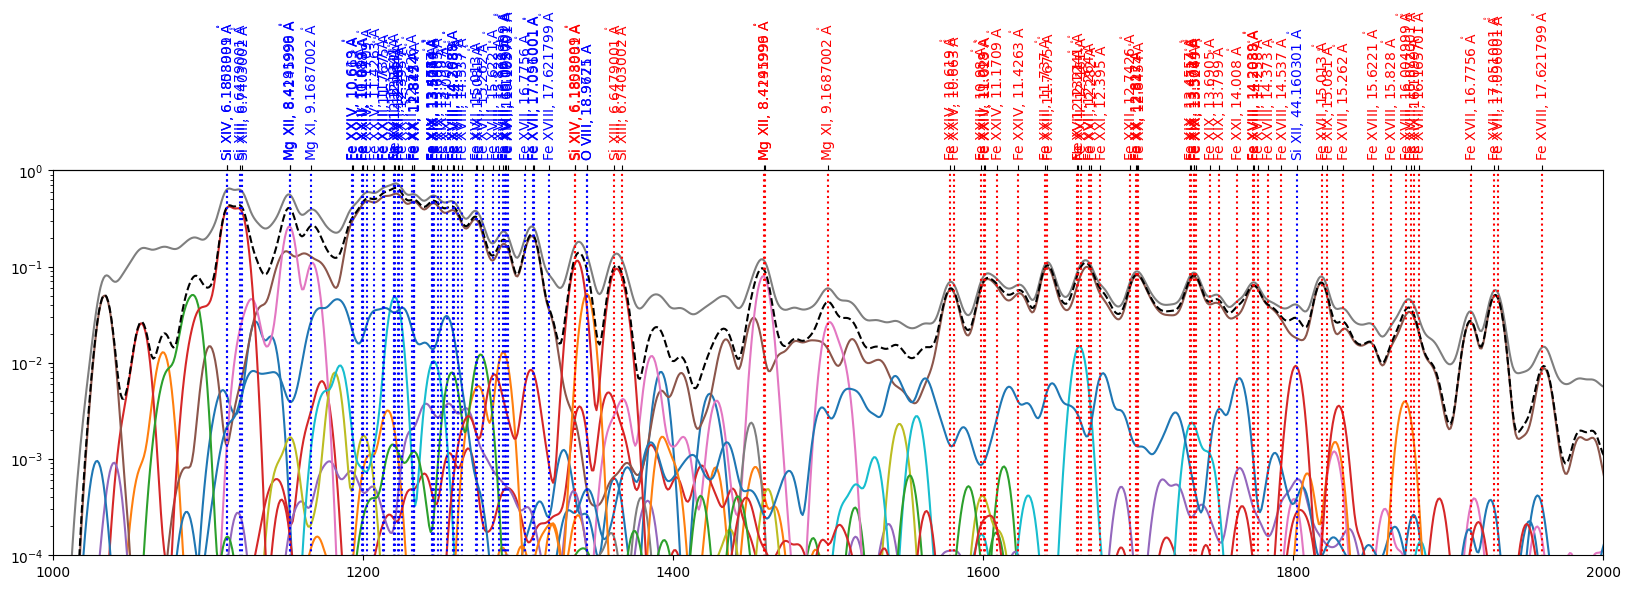

In [38]:
flux_1_all,flux_3_all,flux_total_all = compute_total_flux(dem_flare_ext, spec_tables['sun_coronal_1992_feldman_ext_all'], chan_o1, chan_o3, pix_x_o1, pix_x_o3)
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot()
ax.plot(pix_x_o1, degrade_spectra(flux_total_all, blur, chan_o1).data, color='k', alpha=.5)
total_components = ndcube.NDCube(np.zeros(pix_x_o1.shape), wcs=flux_total_all.wcs, unit=flux_total_all.unit)
for el_name in unique_elements:
    spec_tab = get_spectral_tables(pattern=f'{el_name.lower()}_', sum_tables=True)
    ab = fiasco.Element(el_name, 1*u.MK, abundance_filename='sun_coronal_1992_feldman_ext').abundance
    f1,f3,fall = compute_total_flux(dem_flare_ext, spec_tab, chan_o1, chan_o3, pix_x_o1, pix_x_o3)
    f1 = ab*f1
    f3 = ab*f3
    fall = ab*fall
    total_components += fall.data * fall.unit
    ax.plot(pix_x_o1, degrade_spectra(fall, blur, chan_o1).data, label=el_name.capitalize())
ax.plot(pix_x_o1, degrade_spectra(total_components, blur, chan_o1).data, color='k', ls='--')

# Add vertical lines denoting lines
order_1_color = 'blue'
order_3_color = 'red'
x_pos_1,_,_ = wcs_o1.world_to_pixel(flare_loc, flare_line_labels['wavelength'])
x_pos_3,_,_ = wcs_o3.world_to_pixel(flare_loc, flare_line_labels['wavelength'])
ax.vlines(x_pos_1, 0, 1, ls=':', color=order_1_color,)
ax.vlines(x_pos_3, 0, 1, ls=':', color=order_3_color,)
# Add tick labels for lines
tick_labels = [f'{row["ion name"]}, {row["wavelength"].to_string(format="latex_inline")}' for row in flare_line_labels]
ax_top = ax.secondary_xaxis('top') 
ax_top.set_xticks(np.hstack([x_pos_1, x_pos_3]),
                  labels=tick_labels+tick_labels,
                  rotation=90,
                  horizontalalignment='center',
                  color=order_1_color);
for i,tick in enumerate(ax_top.get_xticklabels()):
    if i>=len(tick_labels):
        tick.set_color(order_3_color)

ax.set_yscale('log')
ax.set_ylim(1e-4,1)
#    ax.set_title(el_name.capitalize())
ax.set_xlim(1000,2000)
#ax.legend(ncol=2)

This next plot looks at the breakdown by ion rather than element.

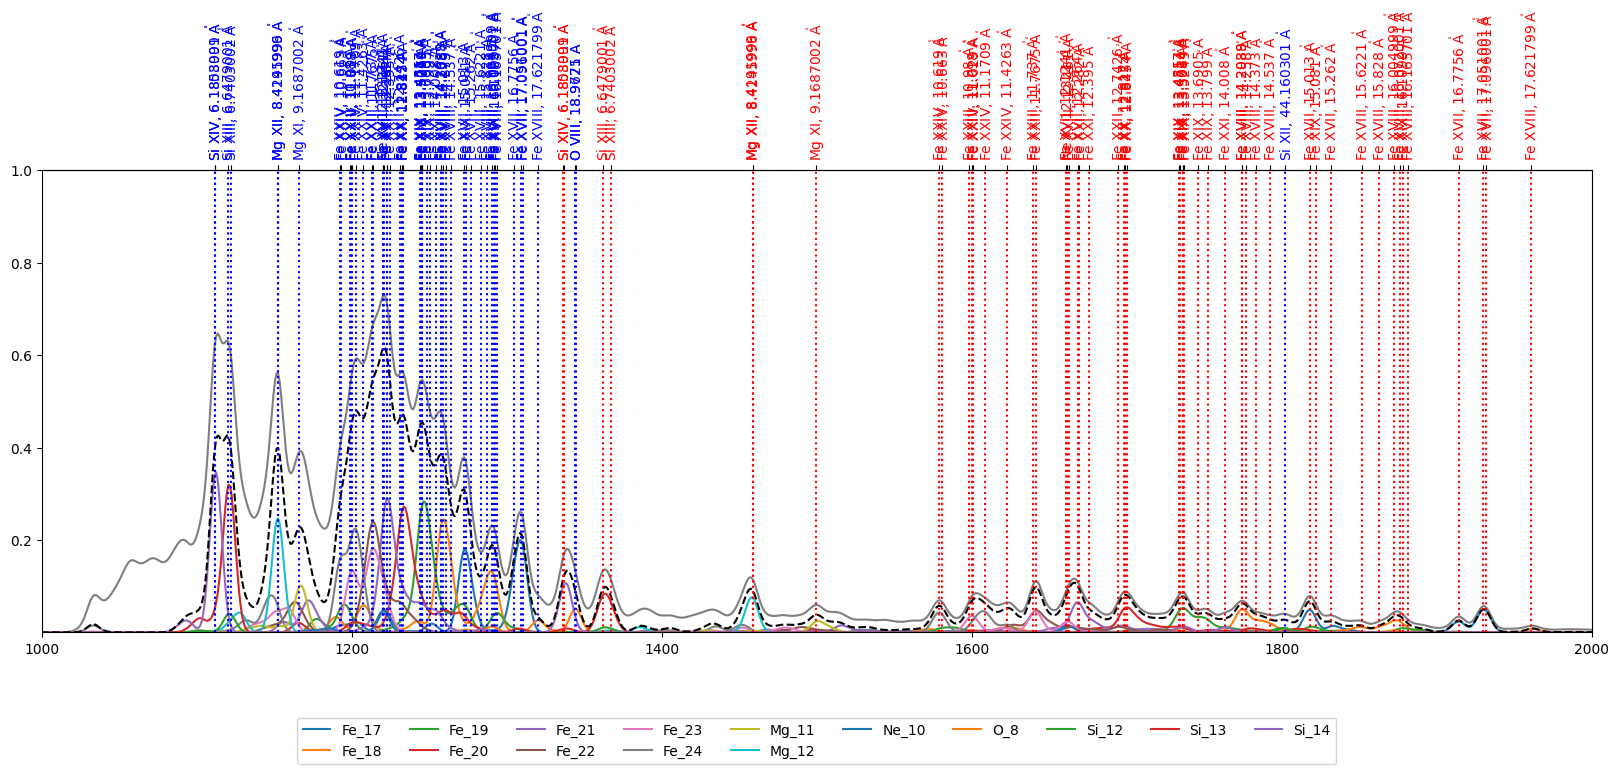

In [39]:
label_lines = True
flux_1_all,flux_3_all,flux_total_all = compute_total_flux(dem_flare_ext, spec_tables['sun_coronal_1992_feldman_ext_all'], chan_o1, chan_o3, pix_x_o1, pix_x_o3)
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot()
ax.plot(pix_x_o1, degrade_spectra(flux_total_all, blur, chan_o1).data, color='k', alpha=.5)
total_components = ndcube.NDCube(np.zeros(pix_x_o1.shape), wcs=flux_total_all.wcs, unit=flux_total_all.unit)
for ion_name in np.unique(flare_line_labels['ion id']):
    spec_tab = get_spectral_tables(pattern=f'{ion_name}', sum_tables=True)
    ab = fiasco.Element(ion_name.split('_')[0], 1*u.MK, abundance_filename='sun_coronal_1992_feldman_ext').abundance
    f1,f3,fall = compute_total_flux(dem_flare_ext, spec_tab, chan_o1, chan_o3, pix_x_o1, pix_x_o3)
    f1 = ab*f1
    f3 = ab*f3
    fall = ab*fall
    total_components += fall.data * fall.unit
    ax.plot(pix_x_o1, degrade_spectra(fall, blur, chan_o1).data, label=ion_name.capitalize())
ax.plot(pix_x_o1, degrade_spectra(total_components, blur, chan_o1).data, color='k', ls='--')

# Add vertical lines denoting lines
order_1_color = 'blue'
order_3_color = 'red'
x_pos_1,_,_ = wcs_o1.world_to_pixel(flare_loc, flare_line_labels['wavelength'])
x_pos_3,_,_ = wcs_o3.world_to_pixel(flare_loc, flare_line_labels['wavelength'])
ax.vlines(x_pos_1, 0, 1, ls=':', color=order_1_color,)
ax.vlines(x_pos_3, 0, 1, ls=':', color=order_3_color,)
# Add tick labels for lines
tick_labels = [f'{row["ion name"]}, {row["wavelength"].to_string(format="latex_inline")}' for row in flare_line_labels]
ax_top = ax.secondary_xaxis('top') 
ax_top.set_xticks(np.hstack([x_pos_1, x_pos_3]),
                  labels=tick_labels+tick_labels,
                  rotation=90,
                  horizontalalignment='center',
                  color=order_1_color);
for i,tick in enumerate(ax_top.get_xticklabels()):
    if i>=len(tick_labels):
        tick.set_color(order_3_color)

#ax.set_yscale('log')
ax.set_ylim(1e-4,1)
#    ax.set_title(el_name.capitalize())
ax.set_xlim(1000,2000)
ax.legend(ncol=10, bbox_to_anchor=(0.5, -0.3), loc='lower center')

### Active Region DEM

#### Components

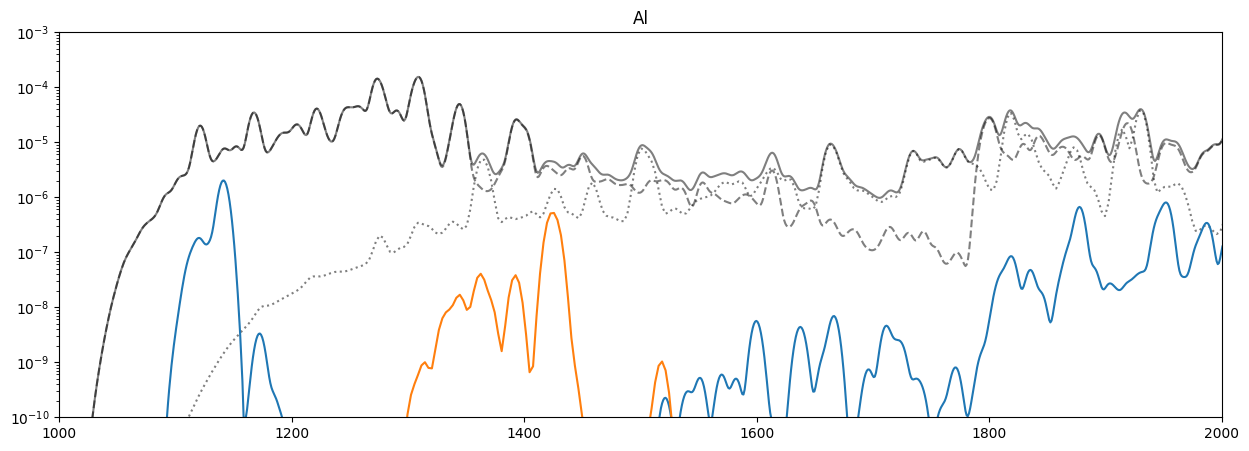

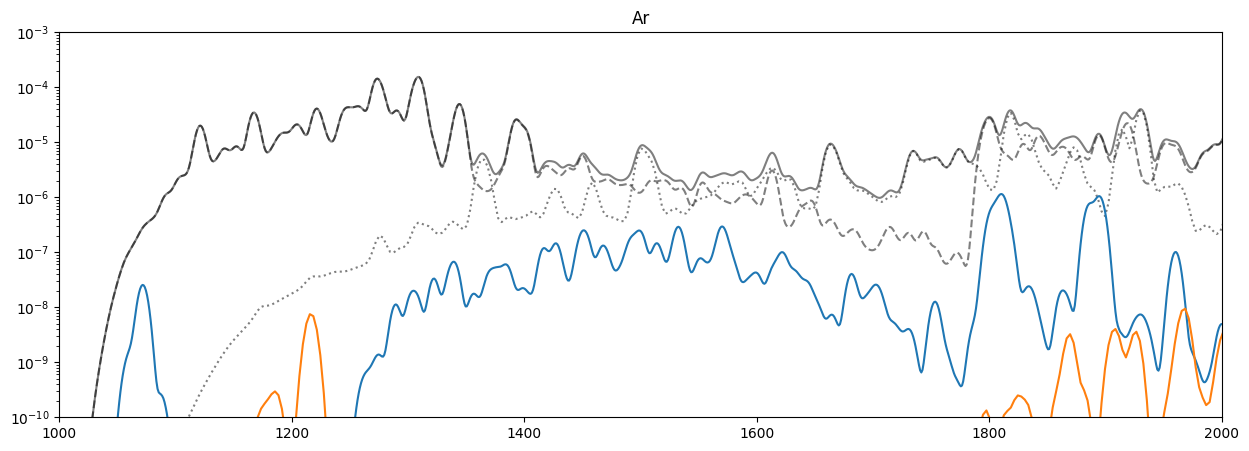

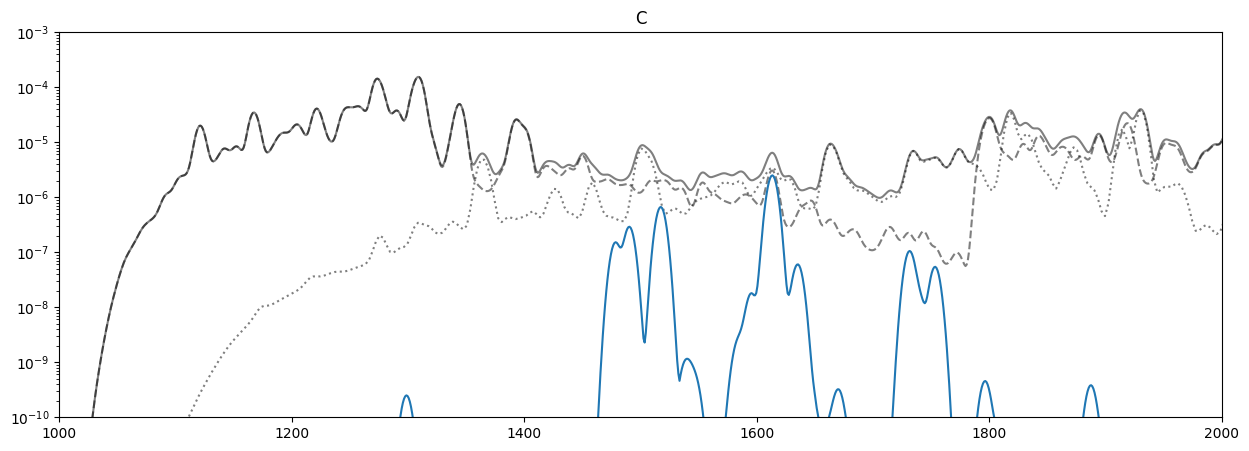

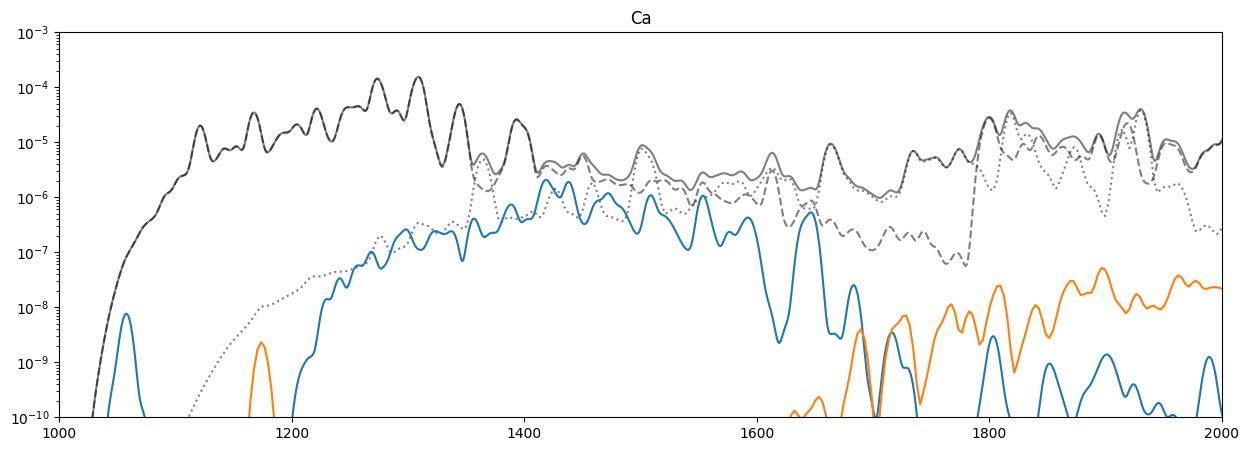

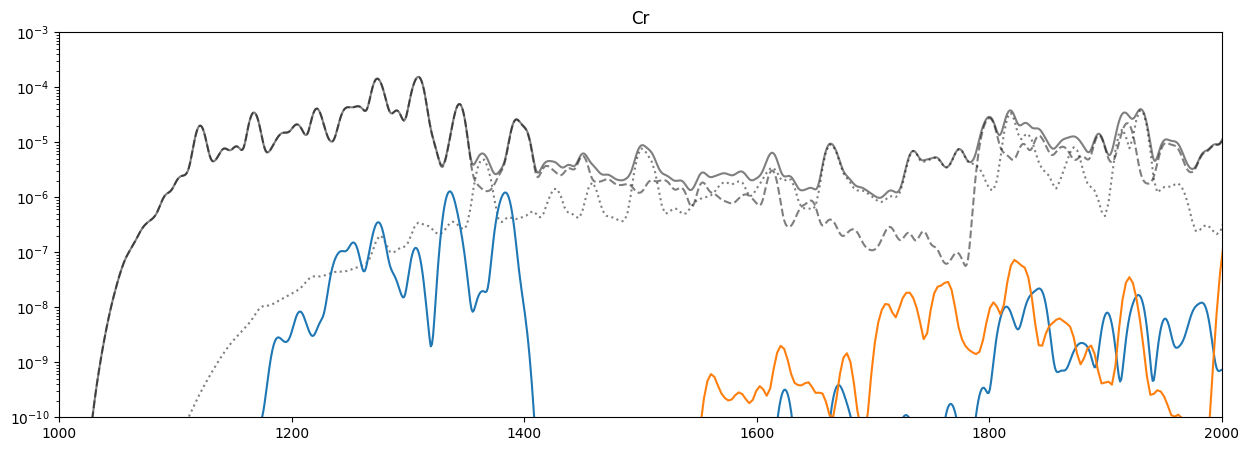

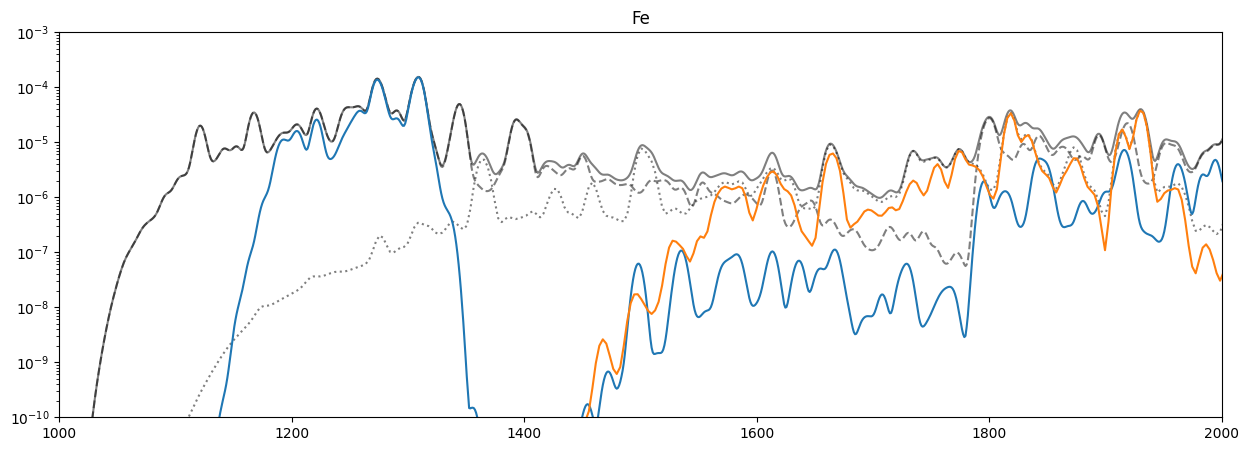

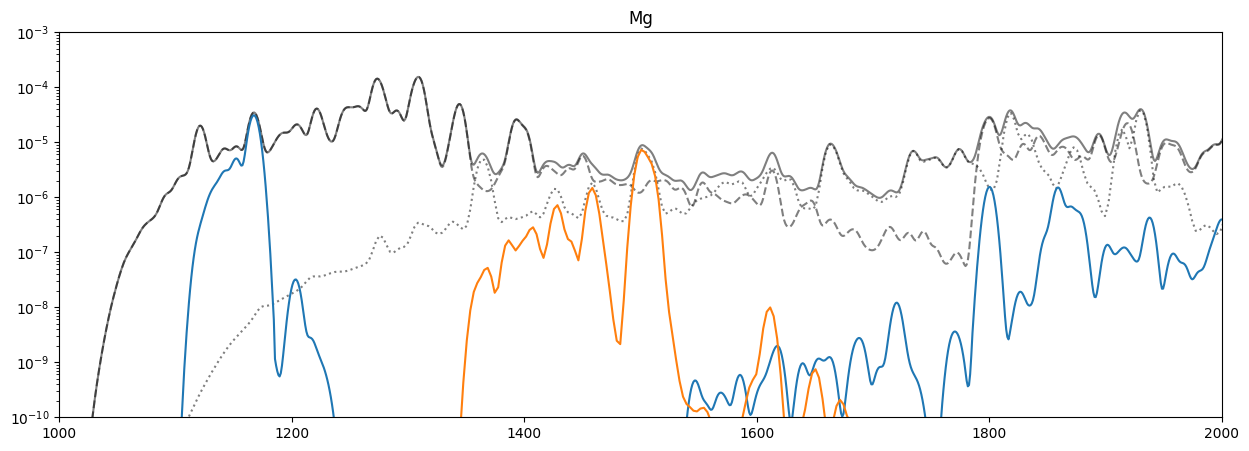

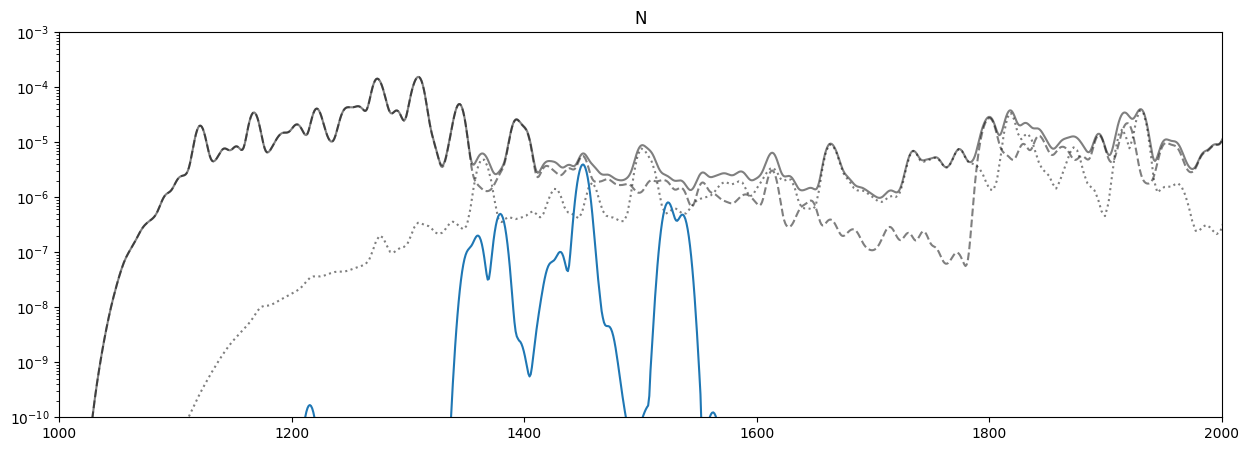

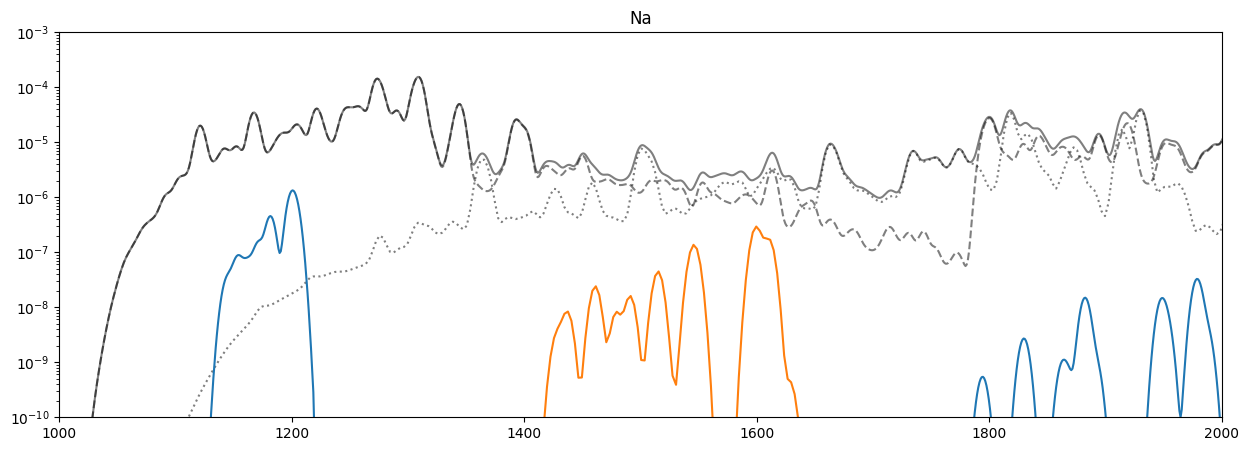

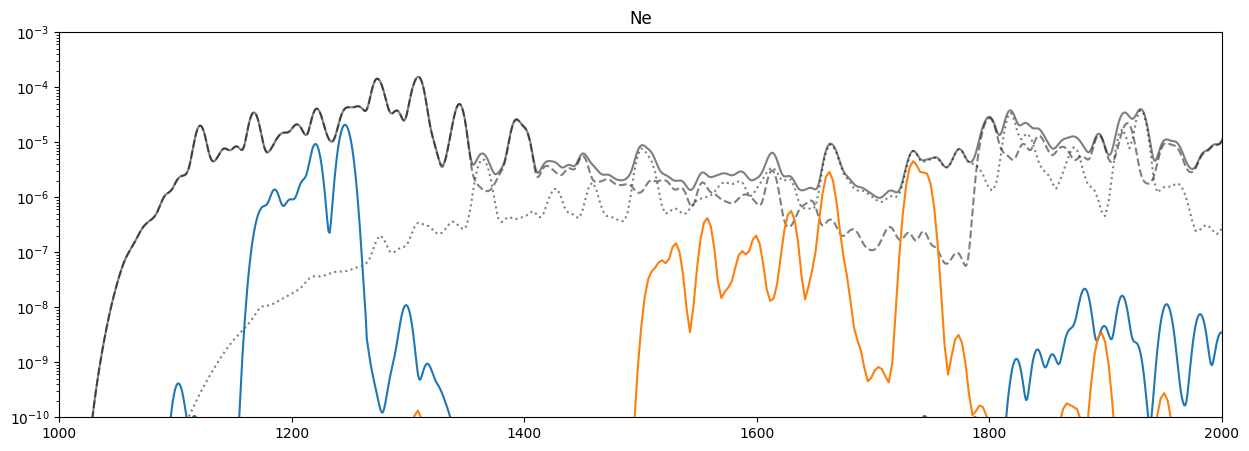

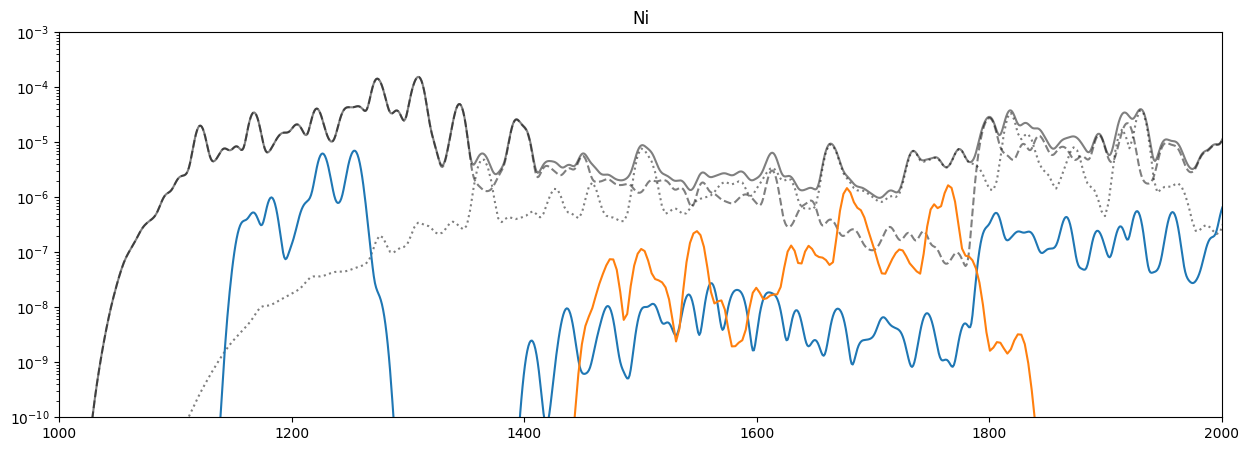

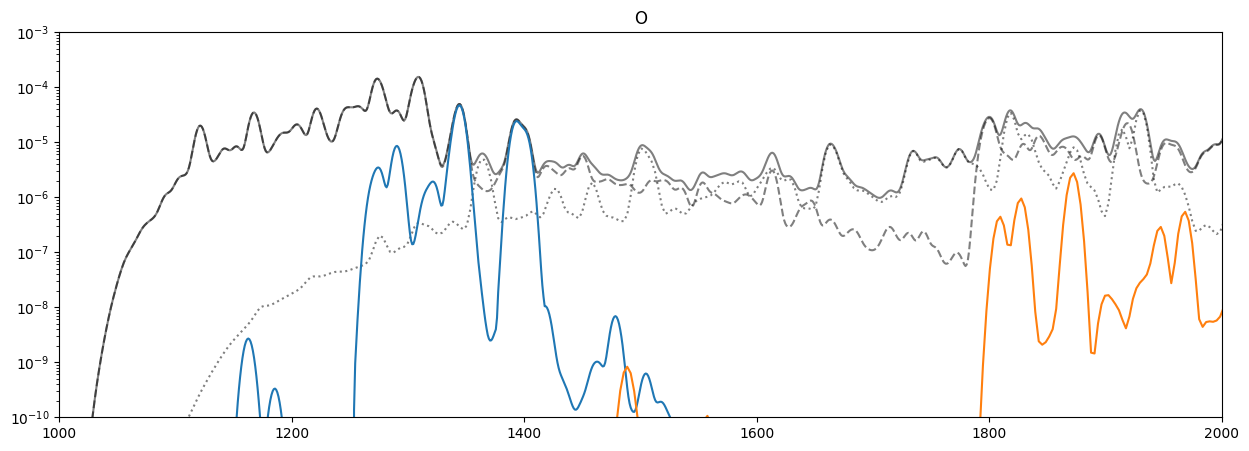

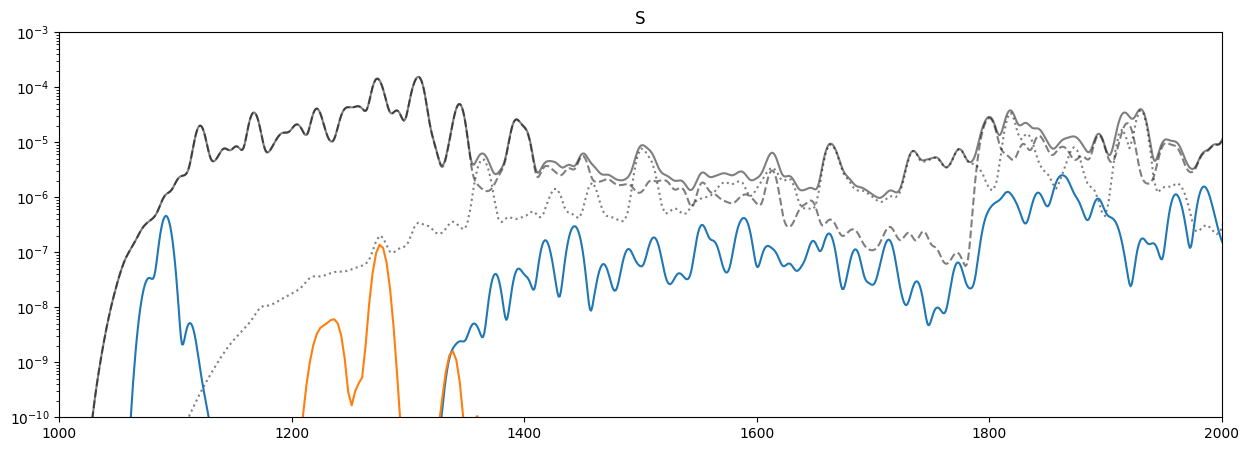

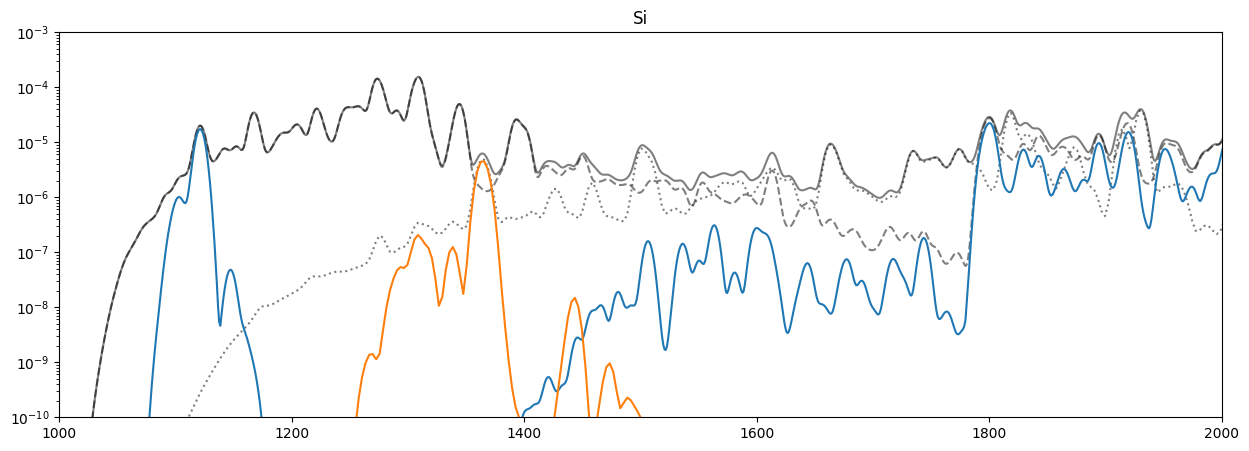

In [41]:
flux_1_all,flux_3_all,flux_total_all = compute_total_flux(dem_ar, spec_tables['sun_coronal_1992_feldman_ext_all'], chan_o1, chan_o3, pix_x_o1, pix_x_o3)
blur = 0.5 * u.Angstrom
flux_1_all = degrade_spectra(flux_1_all, blur, chan_o1)
flux_3_all = degrade_spectra(flux_3_all, blur/3, chan_o1)
flux_total_all = degrade_spectra(flux_total_all, blur, chan_o1)
for el_name in unique_elements:
    spec_tab = get_spectral_tables(pattern=f'{el_name.lower()}_', sum_tables=True)
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()
    ax.plot(pix_x_o1, flux_total_all.data, color='k', alpha=.5)
    ax.plot(pix_x_o1, flux_1_all.data, color='k', alpha=.5, ls='--')
    ax.plot(pix_x_o3, flux_3_all.data, color='k', alpha=.5, ls=':')
    ab = fiasco.Element(el_name, 1*u.MK, abundance_filename='sun_coronal_1992_feldman_ext').abundance
    f1,f3,_ = compute_total_flux(dem_ar, spec_tab, chan_o1, chan_o3, pix_x_o1, pix_x_o3)
    f1 = degrade_spectra(f1, blur, chan_o1)
    f3 = degrade_spectra(f3, blur/3, chan_o1)
    f1 = ab*f1
    f3 = ab*f3
    ax.plot(pix_x_o1, f1.data)
    ax.plot(pix_x_o3, f3.data)
    ax.set_yscale('log')
    ax.set_ylim(1e-10,1e-3)
    ax.set_title(el_name.capitalize())
    ax.set_xlim(1000,2000)

#### Combined

In [290]:
blur = 0.5 * u.angstrom

In [53]:
ar_line_labels = line_list[line_list['intensity_scaled (coronal)_active_region']>0.05]
ar_line_labels = ar_line_labels[['ion name', 'wavelength', 'ion id']]

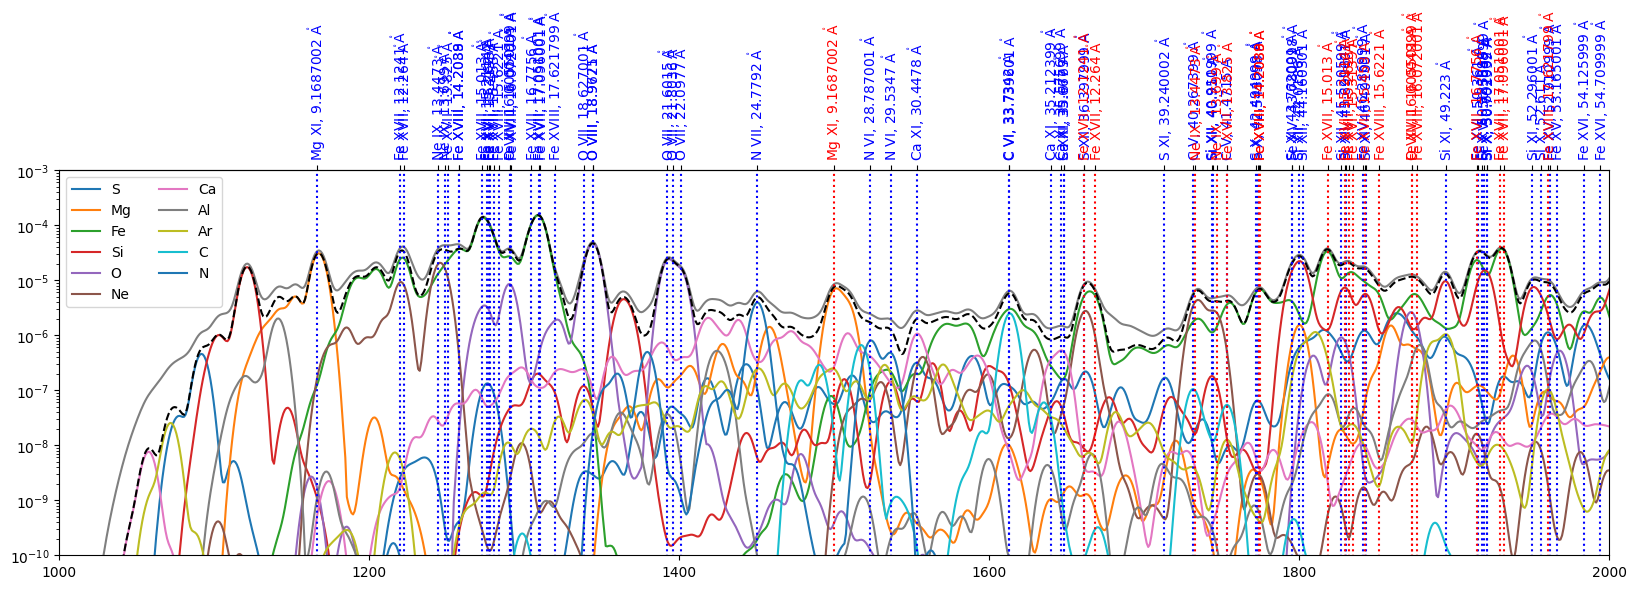

In [54]:
flux_1_all,flux_3_all,flux_total_all = compute_total_flux(dem_ar, spec_tables['sun_coronal_1992_feldman_ext_all'], chan_o1, chan_o3, pix_x_o1, pix_x_o3)
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot()
ax.plot(pix_x_o1, degrade_spectra(flux_total_all, blur, chan_o1).data, color='k', alpha=.5)
total_components = ndcube.NDCube(np.zeros(pix_x_o1.shape), wcs=flux_total_all.wcs, unit=flux_total_all.unit)
for el_name in ['s', 'mg', 'fe', 'si', 'o', 'ne', 'ca', 'al', 'ar', 'c', 'n']:
    spec_tab = get_spectral_tables(pattern=f'{el_name}_', sum_tables=True)
    ab = fiasco.Element(el_name, 1*u.MK, abundance_filename='sun_coronal_1992_feldman_ext').abundance
    f1,f3,fall = compute_total_flux(dem_ar, spec_tab, chan_o1, chan_o3, pix_x_o1, pix_x_o3)
    f1 = ab*f1
    f3 = ab*f3
    fall = ab*fall
    total_components += fall.data * fall.unit
    ax.plot(pix_x_o1, degrade_spectra(fall, blur, chan_o1).data, label=el_name.capitalize())
ax.plot(pix_x_o1, degrade_spectra(total_components, blur, chan_o1).data, color='k', ls='--')

# Add vertical lines denoting lines
order_1_color = 'blue'
order_3_color = 'red'
x_pos_1,_,_ = wcs_o1.world_to_pixel(flare_loc, ar_line_labels['wavelength'])
x_pos_3,_,_ = wcs_o3.world_to_pixel(flare_loc, ar_line_labels['wavelength'])
ax.vlines(x_pos_1, 0, 1, ls=':', color=order_1_color,)
ax.vlines(x_pos_3, 0, 1, ls=':', color=order_3_color,)
# Add tick labels for lines
tick_labels = [f'{row["ion name"]}, {row["wavelength"].to_string(format="latex_inline")}' for row in ar_line_labels]
ax_top = ax.secondary_xaxis('top') 
ax_top.set_xticks(np.hstack([x_pos_1, x_pos_3]),
                  labels=tick_labels+tick_labels,
                  rotation=90,
                  horizontalalignment='center',
                  color=order_1_color);
for i,tick in enumerate(ax_top.get_xticklabels()):
    if i>=len(tick_labels):
        tick.set_color(order_3_color)

ax.set_yscale('log')
ax.set_ylim(1e-10,1e-3)
ax.set_xlim(1000,2000)
ax.legend(ncol=2)

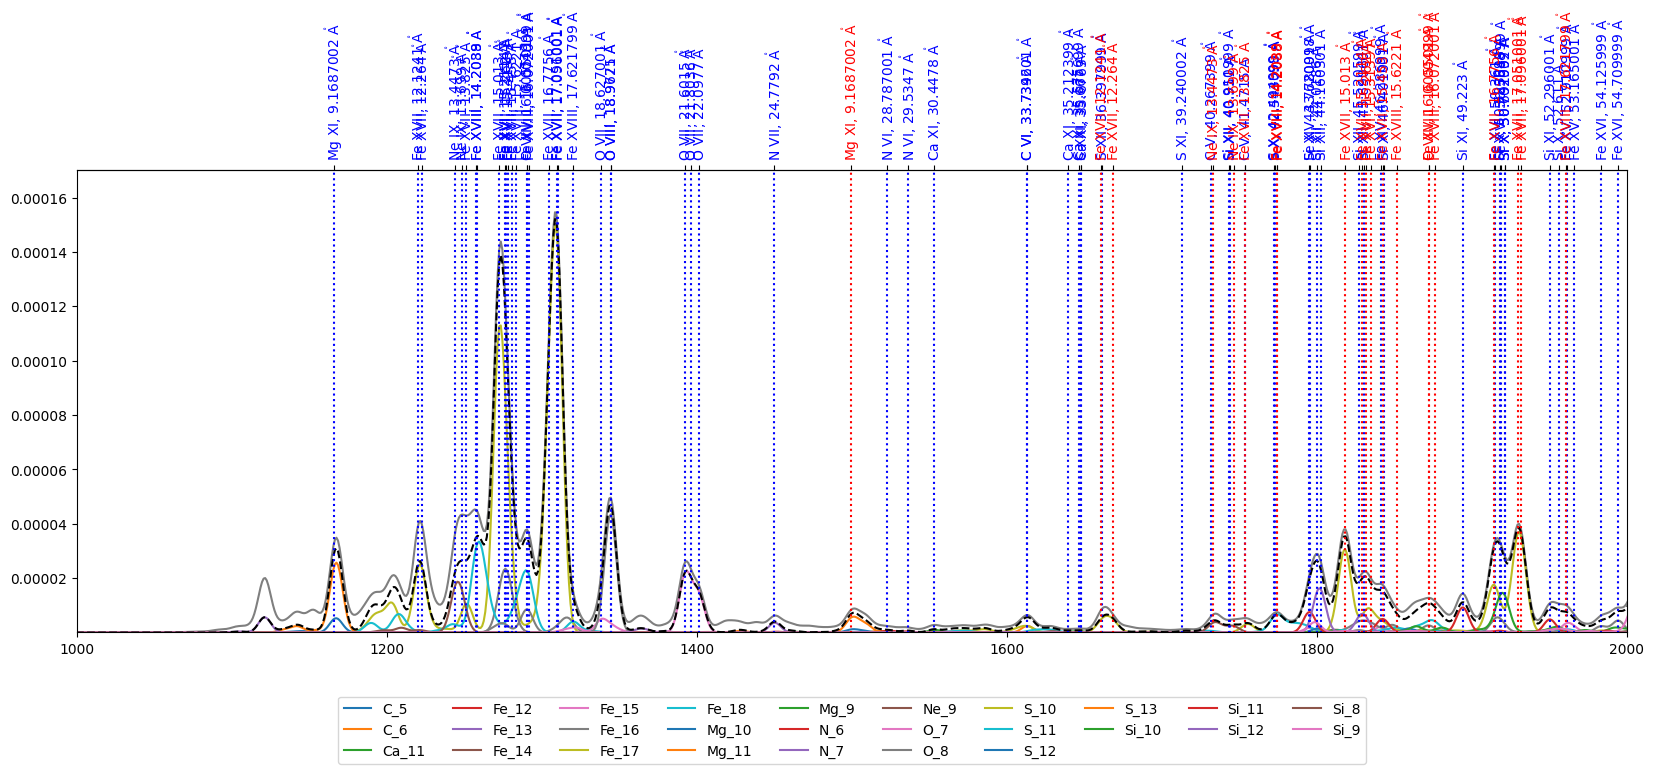

In [55]:
flux_1_all,flux_3_all,flux_total_all = compute_total_flux(dem_ar, spec_tables['sun_coronal_1992_feldman_ext_all'], chan_o1, chan_o3, pix_x_o1, pix_x_o3)
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot()
ax.plot(pix_x_o1, degrade_spectra(flux_total_all, blur, chan_o1).data, color='k', alpha=.5)
total_components = ndcube.NDCube(np.zeros(pix_x_o1.shape), wcs=flux_total_all.wcs, unit=flux_total_all.unit)
for ion_name in np.unique(ar_line_labels['ion id']):
    spec_tab = get_spectral_tables(pattern=f'{ion_name}', sum_tables=True)
    ab = fiasco.Element(ion_name.split('_')[0], 1*u.MK, abundance_filename='sun_coronal_1992_feldman_ext').abundance
    f1,f3,fall = compute_total_flux(dem_ar, spec_tab, chan_o1, chan_o3, pix_x_o1, pix_x_o3)
    f1 = ab*f1
    f3 = ab*f3
    fall = ab*fall
    total_components += fall.data * fall.unit
    ax.plot(pix_x_o1, degrade_spectra(fall, blur, chan_o1).data, label=ion_name.capitalize())
ax.plot(pix_x_o1, degrade_spectra(total_components, blur, chan_o1).data, color='k', ls='--')

# Add vertical lines denoting lines
order_1_color = 'blue'
order_3_color = 'red'
x_pos_1,_,_ = wcs_o1.world_to_pixel(flare_loc, ar_line_labels['wavelength'])
x_pos_3,_,_ = wcs_o3.world_to_pixel(flare_loc, ar_line_labels['wavelength'])
ax.vlines(x_pos_1, 0, 1, ls=':', color=order_1_color,)
ax.vlines(x_pos_3, 0, 1, ls=':', color=order_3_color,)
# Add tick labels for lines
tick_labels = [f'{row["ion name"]}, {row["wavelength"].to_string(format="latex_inline")}' for row in ar_line_labels]
ax_top = ax.secondary_xaxis('top') 
ax_top.set_xticks(np.hstack([x_pos_1, x_pos_3]),
                  labels=tick_labels+tick_labels,
                  rotation=90,
                  horizontalalignment='center',
                  color=order_1_color);
for i,tick in enumerate(ax_top.get_xticklabels()):
    if i>=len(tick_labels):
        tick.set_color(order_3_color)

#ax.set_yscale('log')
ax.set_ylim(1e-7,1.7e-4)
ax.set_xlim(1000,2000)
ax.legend(ncol=10, bbox_to_anchor=(0.5, -0.3), loc='lower center')

## Summarizing Important Lines and Elements

Looking at the breakdown by element for each DEM, the dominant elements are,

- S
- Mg
- Fe
- Si
- O
- Ne
- Ca
- Al
- Ar
- C
- N

Now we want to know within those elements, which ions are the most dominant. In other words, what is the smallest set of ions that we need to account for the prominent spectral features in our bandpass.

- Flaring
  - al 12
  - al 13
  - ca 19
  - ca 20
  - mg 11
  - mg 12
  - ne 9
  - o 8
  - si 11
  - si 12
  - si 13
  - si 14
  - fe 17
  - fe 18
  - fe 19
  - fe 20
  - fe 21
  - fe 22
  - fe 23
  - fe 24
  - fe 25
  - s 15
- AR
  - c 5
  - c 6
  - n 7
  - ca 11
  - ca 12
  - ca 13
  - ca 14
  - ca 15
  - mg 11
  - mg 12
  - ne 9
  - o 7
  - o 8
  - si 9
  - si 10
  - si 11
  - si 12
  - si 13
  - fe 15
  - fe 16
  - fe 17
  - fe 18
  - fe 19

Once we've decided on a minimal set of ions, we should reduce the above table to only lines from those ions and rebuild a more complete table to ensure that we are labeling all of the prominent lines in our bandpass.